In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, precision_recall_curve
from tensorflow.keras.optimizers import Adam, RMSprop
import keras_tuner as kt

## Loading the Dataset

In [2]:
#looking at the preprocessed data
df = pd.read_csv("cleaned_dataset.csv")
df.head(10)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,active,cardio
0,-0.433834,2,0.443711,-0.845741,-0.921194,-0.134931,1,1,0,1,0
1,0.309613,1,-1.018961,0.759448,0.771644,0.877460,3,1,0,1,1
2,-0.245845,1,0.078043,-0.706160,0.207365,-1.147322,3,1,0,0,1
3,-0.745799,2,0.565600,0.550076,1.335923,1.889851,1,1,0,1,1
4,-0.806166,1,-1.018961,-1.264486,-1.485474,-2.159713,1,1,0,0,0
5,0.992694,1,-1.628408,-0.496787,-0.356915,-0.134931,2,2,0,0,0
6,1.073318,1,-0.897072,1.317775,0.207365,-0.134931,3,1,0,1,0
7,1.264143,2,1.662604,1.457357,0.207365,0.877460,3,3,0,1,1
8,-0.727567,1,-0.775183,-0.217624,-0.921194,-1.147322,1,1,0,1,0
9,0.149985,1,-0.043847,-0.426996,-0.921194,-2.159713,1,1,0,0,0


## Splitting the dataset into training and test set

In [3]:
X = df.drop(["cardio"],axis=1)
y = df["cardio"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

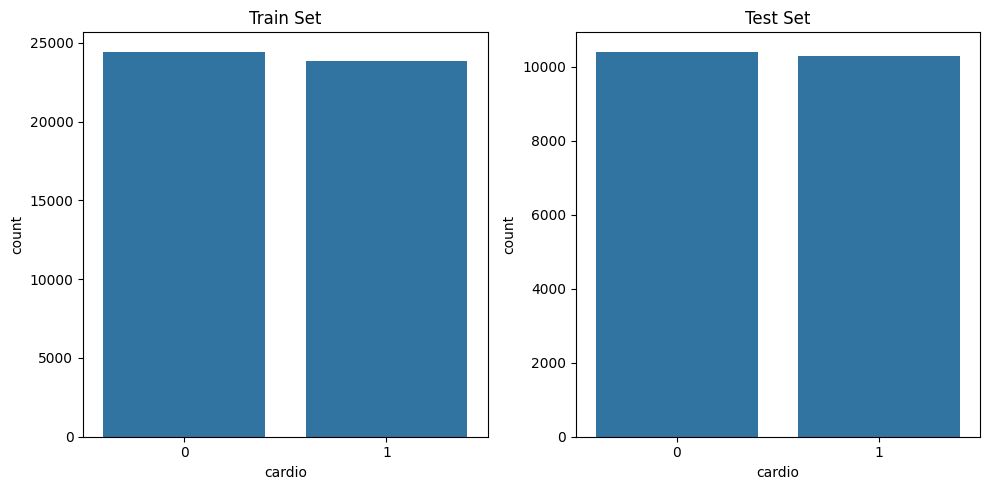

In [4]:
#looking at the counts for training and test dataset
fig, ax = plt.subplots(1,2,figsize = (10,5))
sns.countplot(data=df, x = y_train, ax = ax[0])
ax[0].set_title("Train Set")
sns.countplot(data=df, x = y_test, ax = ax[1])
ax[1].set_title("Test Set")
plt.tight_layout()

## Choosing the network architecture

### Wide and short

#### Building and training the model

In [5]:
# Define model
model = Sequential()
model.add(Dense(units=512, activation='relu'))      #Layer 1
model.add(Dense(units =256, activation='relu'))     #Layer 2
model.add(Dense(units=64, activation='relu'))       #Layer 3
model.add(Dense(units=1, activation='sigmoid'))     #Output Layer

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy', tf.keras.metrics.Recall(name="recall")]
)


In [6]:
# Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    verbose=0)

#### Plotting different metrics with each epoch

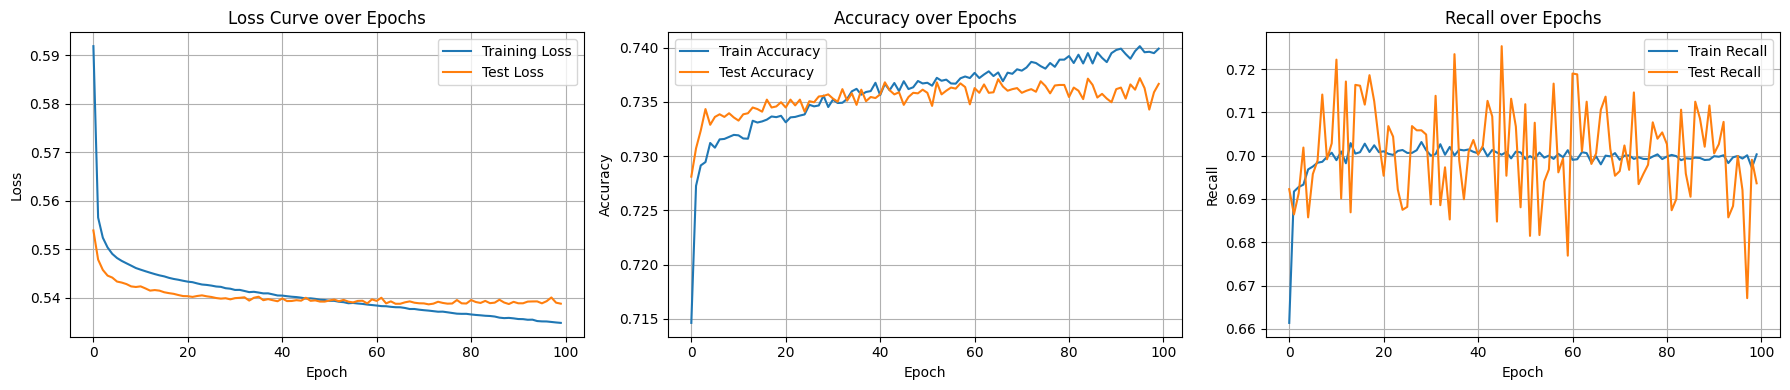

In [7]:
plt.figure(figsize=(18, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve over Epochs')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(1, 3, 3)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Test Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Predicting on test set

In [8]:
y_pred = model.predict(X_test,verbose=0)
y_pred_classes = (y_pred>=0.5).astype(int)  #hard threshold of 0.5

In [9]:
#building confusion matrix
con_matrix = confusion_matrix(y_test, y_pred_classes)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,8113,2299
Actual 1,3152,7136


In [10]:
#evaluating performance of the best single layer model
accuracy = accuracy_score(y_test, y_pred_classes) *100
precision = precision_score(y_test, y_pred_classes) *100
recall = recall_score(y_test, y_pred_classes) *100
f1 = f1_score(y_test,y_pred_classes) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 73.67%
Precision: 75.63%
Recall: 69.36%
F1_score: 72.36%


#### Adaptive Softening using Precision-Recall curve

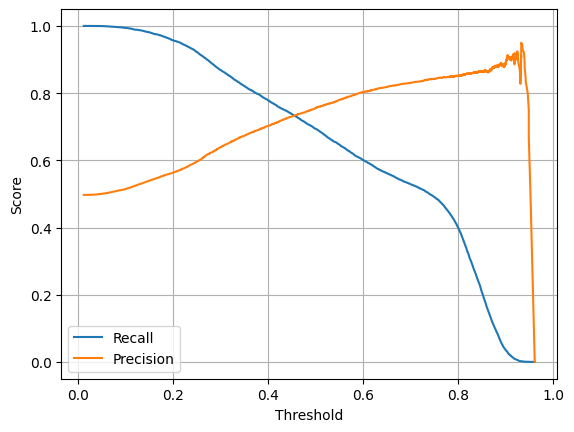

In [11]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, precision[:-1], label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

In [12]:
# Compute PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Use boolean mask to filter thresholds ≥ 0.4
thresholds_filtered = thresholds[abs(thresholds -0.5) >= 0.1]
recall_filtered = recall[:-1][abs(thresholds -0.5) >= 0.1]  # recall[:-1] matches threshold length

# Pick highest threshold ≥ 0.4 that meets recall ≥ 0.80
target_recall = 0.80
best_thresh = 0.5  # fallback if not found

for r, t in zip(recall_filtered[::-1], thresholds_filtered[::-1]):
    if r >= target_recall:
        best_thresh = t
        break

print(f"Selected threshold: {best_thresh:.2f} with recall ≥ {target_recall}")

Selected threshold: 0.37 with recall ≥ 0.8


In [13]:
#predicting on test set
y_pred = model.predict(X_test,verbose=0)
y_pred_classes = (y_pred>=best_thresh).astype(int)

In [14]:
#building confusion matrix
con_matrix = confusion_matrix(y_test, y_pred_classes)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,6678,3734
Actual 1,2057,8231


In [15]:
#evaluating performance of the best single layer model
accuracy = accuracy_score(y_test, y_pred_classes) *100
precision = precision_score(y_test, y_pred_classes) *100
recall = recall_score(y_test, y_pred_classes) *100
f1 = f1_score(y_test,y_pred_classes) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 72.02%
Precision: 68.79%
Recall: 80.01%
F1_score: 73.98%


### Deep and Narrow

#### Building and training the model

In [16]:
model = Sequential()

model.add(Dense(units= 150, activation= ReLU()))    #Layer 1
model.add(Dense(units= 130, activation= ReLU()))    #Layer 2
model.add(Dense(units= 110, activation= ReLU()))    #Layer 3
model.add(Dense(units= 90, activation= ReLU()))     #Layer 4
model.add(Dense(units= 70, activation= ReLU()))     #Layer 5
model.add(Dense(units= 50, activation= ReLU()))     #Layer 6
model.add(Dense(units= 40, activation= ReLU()))     #Layer 7
model.add(Dense(units= 30, activation=ReLU()))      #Layer 8
model.add(Dense(units= 20, activation= ReLU()))     #Layer 9
model.add(Dense(units=1, activation="sigmoid"))     #Output Layer

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy', tf.keras.metrics.Recall(name="recall")]
)

In [17]:
# Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    verbose=0)

#### Plotting different metrics with each epoch

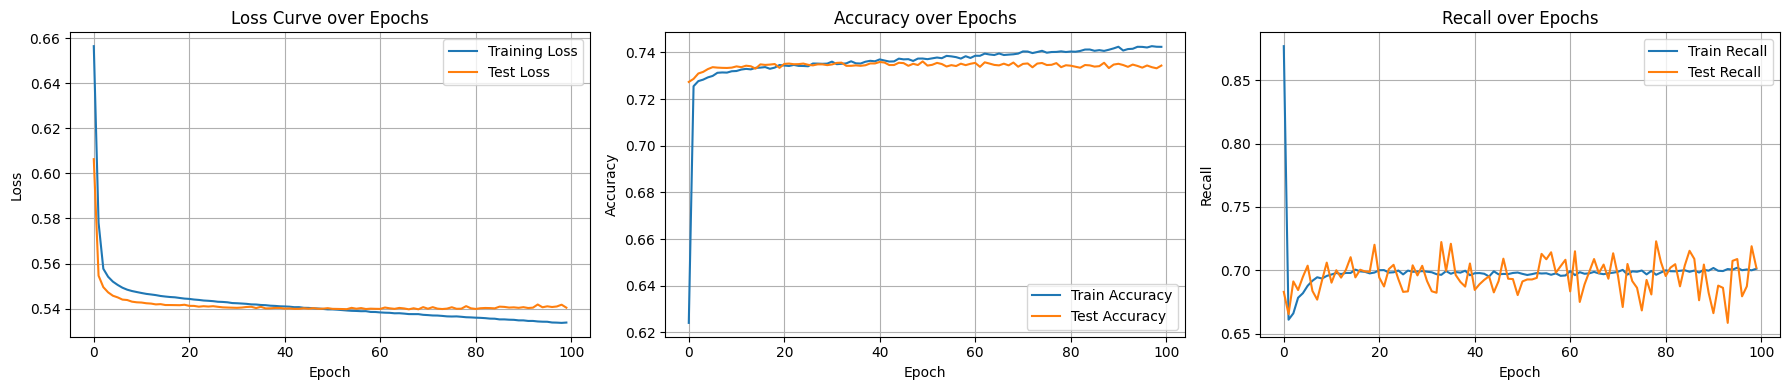

In [18]:
plt.figure(figsize=(18, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve over Epochs')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(1, 3, 3)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Test Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Predicting on test set

In [19]:
y_pred = model.predict(X_test,verbose=0)
y_pred_classes = (y_pred>=0.5).astype(int)

In [20]:
#building confusion matrix
con_matrix = confusion_matrix(y_test, y_pred_classes)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,7979,2433
Actual 1,3066,7222


In [21]:
#evaluating performance of the best single layer model
accuracy = accuracy_score(y_test, y_pred_classes) *100
precision = precision_score(y_test, y_pred_classes) *100
recall = recall_score(y_test, y_pred_classes) *100
f1 = f1_score(y_test,y_pred_classes) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 73.43%
Precision: 74.80%
Recall: 70.20%
F1_score: 72.43%


#### Adaptive Softening using Precision-Recall Curve

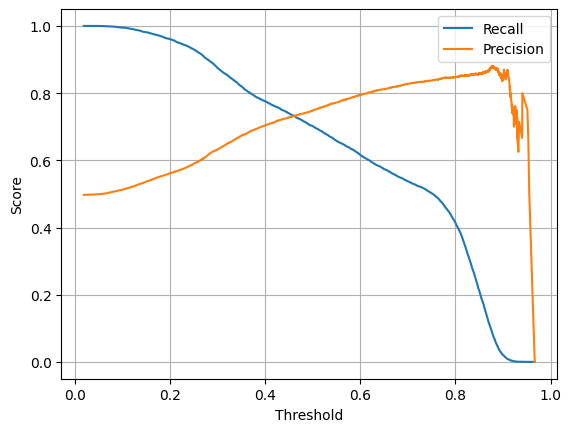

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, precision[:-1], label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

In [23]:
# Compute PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Use boolean mask to filter thresholds ≥ 0.4
thresholds_filtered = thresholds[abs(thresholds -0.5) >= 0.1]
recall_filtered = recall[:-1][abs(thresholds -0.5) >= 0.1]  # recall[:-1] matches threshold length

# Pick highest threshold ≥ 0.4 that meets recall ≥ 0.80
target_recall = 0.80
best_thresh = 0.5  # fallback if not found

for r, t in zip(recall_filtered[::-1], thresholds_filtered[::-1]):
    if r >= target_recall:
        best_thresh = t
        break

print(f"Selected threshold: {best_thresh:.2f} with recall ≥ {target_recall}")

Selected threshold: 0.37 with recall ≥ 0.8


In [24]:
#predicting on test set
y_pred = model.predict(X_test,verbose=0)
y_pred_classes = (y_pred>=best_thresh).astype(int)

In [25]:
#building confusion matrix
con_matrix = confusion_matrix(y_test, y_pred_classes)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,6649,3763
Actual 1,2057,8231


In [26]:
#evaluating performance of the best single layer model
accuracy = accuracy_score(y_test, y_pred_classes) *100
precision = precision_score(y_test, y_pred_classes) *100
recall = recall_score(y_test, y_pred_classes) *100
f1 = f1_score(y_test,y_pred_classes) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 71.88%
Precision: 68.63%
Recall: 80.01%
F1_score: 73.88%


### Medium

#### Building and training the model

In [27]:
model = Sequential()

model.add(Dense(units= 300, activation= ReLU()))    #Layer 1
model.add(Dense(units= 200, activation= ReLU()))    #Layer 2
model.add(Dense(units= 150, activation= ReLU()))    #Layer 3
model.add(Dense(units= 75, activation= ReLU()))     #Layer 4
model.add(Dense(units= 50, activation= ReLU()))     #Layer 5
model.add(Dense(units= 25, activation= ReLU()))     #Layer 6
model.add(Dense(units=1, activation="sigmoid"))     #Output Layer

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy', tf.keras.metrics.Recall(name="recall")]
)

In [28]:
# Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    verbose=0)

#### Plotting different metrics with each epoch

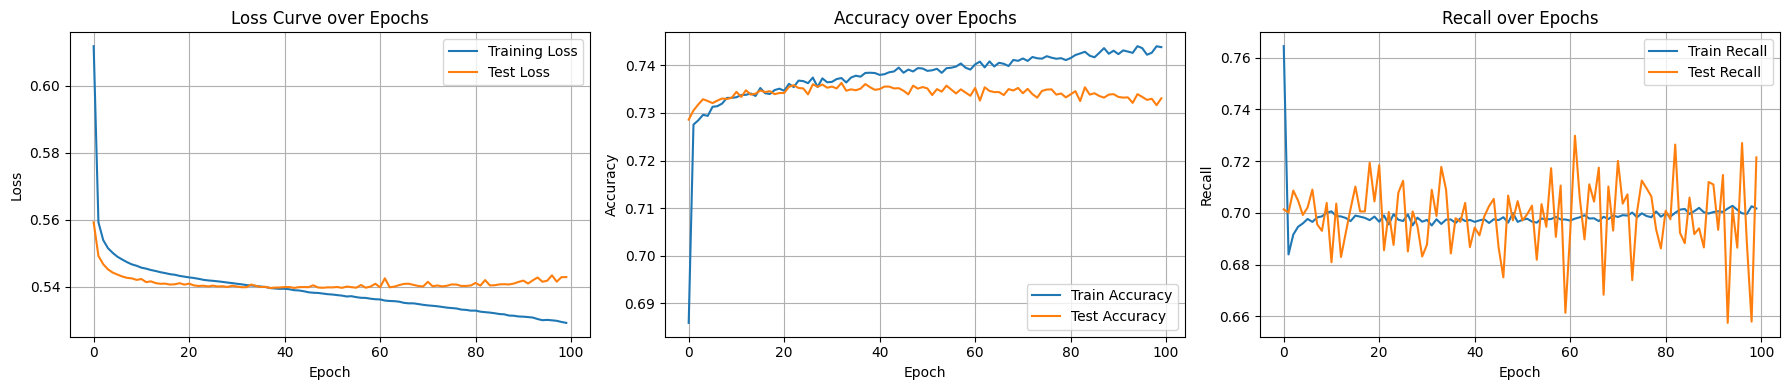

In [29]:
plt.figure(figsize=(18, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve over Epochs')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(1, 3, 3)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Test Recall')
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Prediting on test set

In [30]:
y_pred = model.predict(X_test,verbose=0)
y_pred_classes = (y_pred>=0.5).astype(int)

In [31]:
#building confusion matrix
con_matrix = confusion_matrix(y_test, y_pred_classes)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,7753,2659
Actual 1,2866,7422


In [32]:
#evaluating performance of the best single layer model
accuracy = accuracy_score(y_test, y_pred_classes) *100
precision = precision_score(y_test, y_pred_classes) *100
recall = recall_score(y_test, y_pred_classes) *100
f1 = f1_score(y_test,y_pred_classes) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 73.31%
Precision: 73.62%
Recall: 72.14%
F1_score: 72.88%


#### Adaptive Softening using Precision-Recall Curve

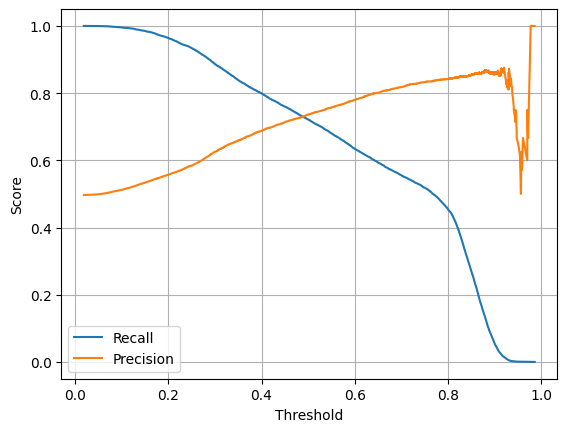

In [33]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, precision[:-1], label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

In [34]:
# Compute PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Use boolean mask to filter thresholds ≥ 0.4
thresholds_filtered = thresholds[abs(thresholds -0.5) >= 0.1]
recall_filtered = recall[:-1][abs(thresholds -0.5) >= 0.1]  # recall[:-1] matches threshold length

# Pick highest threshold ≥ 0.4 that meets recall ≥ 0.80
target_recall = 0.80
best_thresh = 0.5  # fallback if not found

for r, t in zip(recall_filtered[::-1], thresholds_filtered[::-1]):
    if r >= target_recall:
        best_thresh = t
        break

print(f"Selected threshold: {best_thresh:.2f} with recall ≥ {target_recall}")

Selected threshold: 0.40 with recall ≥ 0.8


In [35]:
#predicitng on test set
y_pred = model.predict(X_test,verbose=0)
y_pred_classes = (y_pred>=best_thresh).astype(int)

In [36]:
#building confusion matrix
con_matrix = confusion_matrix(y_test, y_pred_classes)
con_matrix = pd.DataFrame(data = con_matrix, columns= ["Predicted 0","Predicted 1"], index= ["Actual 0", "Actual 1"])
con_matrix

,Predicted 0,Predicted 1
Actual 0,6671,3741
Actual 1,2057,8231


In [37]:
#evaluating performance of the best single layer model
accuracy = accuracy_score(y_test, y_pred_classes) *100
precision = precision_score(y_test, y_pred_classes) *100
recall = recall_score(y_test, y_pred_classes) *100
f1 = f1_score(y_test,y_pred_classes) *100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1_score: {f1:.2f}%")

Accuracy: 71.99%
Precision: 68.75%
Recall: 80.01%
F1_score: 73.95%
